In [1]:
!pip install -q shapely

In [53]:
import pyspark
from delta import *
from pyspark.sql import Window
from pyspark.sql.types import StringType, DoubleType
import pyspark.sql.functions as F
from shapely.geometry import shape, Point, Polygon
from shapely.strtree import STRtree
from shapely import wkt
import matplotlib.pyplot as plt
import json
import time



builder = pyspark.sql.SparkSession.builder.appName("NY_TaxiAnalysis") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") 

spark = configure_spark_with_delta_pip(builder).getOrCreate()

spark.conf.set("spark.sql.repl.eagerEval.enabled",True)
spark.conf.set("spark.sql.repl.eagerEval.truncate", 500)


# Boroughs enrichment 

In [54]:
boroughs_df = (spark.read
               .json("nyc-boroughs.geojson"))

boroughs_df = boroughs_df.drop("_corrupt_record").dropna()

def coord_to_poly(geometry):
    return shape(geometry.asDict()).wkt

udf_polygon = F.udf(coord_to_poly, StringType())
boroughs_df = boroughs_df.withColumn("polygon", udf_polygon(boroughs_df["geometry"]))

# adding area and sorting
def area(geometry):
    return shape(geometry.asDict()).area
    
udf_area = F.udf(area, DoubleType())
boroughs_df = boroughs_df.withColumn("area", udf_area(boroughs_df["geometry"]))

#sorting
boroughs_df = boroughs_df.sort(F.desc("properties.boroughCode"), F.desc("area"))

#broadcasting
# boroughs_b_df = spark.sparkContext.broadcast(boroughs_df.collect())

boroughs_df.printSchema()

root
 |-- geometry: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: array (containsNull = true)
 |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- id: long (nullable = true)
 |-- properties: struct (nullable = true)
 |    |-- @id: string (nullable = true)
 |    |-- borough: string (nullable = true)
 |    |-- boroughCode: long (nullable = true)
 |-- type: string (nullable = true)
 |-- polygon: string (nullable = true)
 |-- area: double (nullable = true)



In [55]:
boroughs_df.limit(1)

geometry,id,properties,type,polygon,area
"{[[[-74.08221272914938, 40.64828016229008], [-74.08142228203805, 40.64850472594939], [-74.08072838762374, 40.64827487384626], [-74.07980996428705, 40.648383312987924], [-74.07899546333259, 40.648142554422414], [-74.0765065715286, 40.646968818183346], [-74.074452825637, 40.645067488723235], [-74.07395839976468, 40.645193205445516], [-74.07359107919278, 40.64499892804299], [-74.07349851367621, 40.6450833734751], [-74.07385653684726, 40.645424816099606], [-74.07333813856985, 40.64578311616224], ...",3,"{http://nyc.pediacities.com/Resource/Borough/Staten_Island, Staten Island, 5}",Feature,"POLYGON ((-74.08221272914938 40.64828016229008, -74.08142228203805 40.64850472594939, -74.08072838762374 40.64827487384626, -74.07980996428705 40.648383312987924, -74.07899546333259 40.648142554422414, -74.0765065715286 40.646968818183346, -74.074452825637 40.645067488723235, -74.07395839976468 40.645193205445516, -74.07359107919278 40.64499892804299, -74.07349851367621 40.6450833734751, -74.07385653684726 40.645424816099606, -74.07333813856985 40.64578311616224, -74.07324539464854 40.6457049...",0.01603547601912208


# STRtree building

In [125]:
boroughs_polygons = []
boroughs_list = boroughs_df.collect()
boroughs_list_b = spark.sparkContext.broadcast(boroughs_list)

for row in boroughs_list:
    poly = wkt.loads(row["polygon"])
    boroughs_polygons.append(poly)

In [126]:
str_tree = STRtree(boroughs_polygons)
str_tree_b =  spark.sparkContext.broadcast(str_tree)

# Taxi filtering

In [58]:
taxi_df = (spark.read
            .option("header", "true")
            .option("inferSchema", "true")
             .csv("sample.csv")
            )
taxi_df.printSchema()

root
 |-- medallion: string (nullable = true)
 |-- hack_license: string (nullable = true)
 |-- vendor_id: string (nullable = true)
 |-- rate_code: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_time_in_secs: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)



In [59]:
taxi_df.limit(1)

medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
89D227B655E5C82AECF13C3F540D4CF4,BA96DE419E711691B9445D6A6307C170,CMT,1,N,2013-01-01 15:11:48,2013-01-01 15:18:10,4,382,1.0,-73.978165,40.757977,-73.989838,40.751171


In [60]:
# < 4 hours
taxi_df = taxi_df.filter((F.col("trip_time_in_secs") < 14400) & 
                         (F.col("trip_time_in_secs") > 0))
taxi_df.count()

99550

In [61]:
# unix
taxi_df = (taxi_df
           .withColumn("pickup_ts", F.unix_timestamp("pickup_datetime"))
           .withColumn("dropoff_ts", F.unix_timestamp("dropoff_datetime"))
           .filter(F.col("pickup_ts") - F.col("dropoff_ts") < 0)
          )
taxi_df.count()

99550

In [62]:
# removing 0 lon & lat
taxi_df = taxi_df.filter(
    (F.col("pickup_longitude") != 0) &
    (F.col("pickup_latitude") != 0) &
    (F.col("dropoff_longitude") != 0) &
    (F.col("dropoff_latitude") != 0)
)
taxi_df.count()

97889

In [63]:
# >0 passenger
taxi_df = taxi_df.filter(F.col("passenger_count") > 0)
taxi_df.count()

97888

In [64]:
# >0 trip
taxi_df = taxi_df.filter(F.col("trip_distance") > 0)
taxi_df.count()

97801

In [65]:
taxi_df = taxi_df.filter(F.col("pickup_ts") < F.col("dropoff_ts"))
taxi_df.count()

97801

In [36]:
# taxi_df.withColumn("diff", F.col("dropoff_ts") - F.col("pickup_ts")).filter(F.col("diff") != F.col("trip_time_in_secs"))

# Taxi enrichment

In [150]:
# version 1
def locate_borough(lon, lat):
    point = Point(lon, lat)
    for row in boroughs_b_df.value:
        pol = wkt.loads(row["polygon"])
        if point.within(pol):
            return row["properties"]["borough"]
    return None

udf_borough = F.udf(locate_borough, StringType())
taxi_df = taxi_df.withColumn("pickup_borough", udf_borough(taxi_df["pickup_longitude"], taxi_df["pickup_latitude"]))
taxi_df = taxi_df.withColumn("dropoff_borough", udf_borough(taxi_df["dropoff_longitude"], taxi_df["dropoff_latitude"]))

In [ ]:
# version 2
def locate_borough_str(lon, lat):
    point = Point(lon, lat)
    str_tree = str_tree_b.value
    borough_idx = str_tree.nearest(point)
    boroughs_list = boroughs_list_b.value
    borough = boroughs_list[borough_idx]["properties"]["borough"]
    return borough

udf_borough_str = F.udf(locate_borough_str, StringType())
taxi_df = taxi_df.withColumn("pickup_borough", udf_borough_str(taxi_df["pickup_longitude"], taxi_df["pickup_latitude"]))
taxi_df = taxi_df.withColumn("dropoff_borough", udf_borough_str(taxi_df["dropoff_longitude"], taxi_df["dropoff_latitude"]))

In [28]:
taxi_df.limit(1)

medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_ts,dropoff_ts
89D227B655E5C82AECF13C3F540D4CF4,BA96DE419E711691B9445D6A6307C170,CMT,1,N,2013-01-01 15:11:48,2013-01-01 15:18:10,4,382,1.0,-73.978165,40.757977,-73.989838,40.751171,1357053108,1357053490


In [138]:
taxi_df.printSchema()

root
 |-- medallion: string (nullable = true)
 |-- hack_license: string (nullable = true)
 |-- vendor_id: string (nullable = true)
 |-- rate_code: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_time_in_secs: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- pickup_ts: long (nullable = true)
 |-- dropoff_ts: long (nullable = true)
 |-- pickup_borough: string (nullable = true)
 |-- dropoff_borough: string (nullable = true)



# Query 1

In [145]:
window_taxi = Window.partitionBy("medallion").orderBy("pickup_ts")
utilization_df = (taxi_df
               .withColumn("prev_dropoff_ts", F.lag("dropoff_ts").over(window_taxi))
               .withColumn("idle_time", F.col("pickup_ts") - F.col("prev_dropoff_ts"))
               .filter((F.col("idle_time") <= 14400) & (F.col("idle_time") > 0))
               .groupBy("medallion")
               .agg(
                   F.sum("trip_time_in_secs").alias("total_active_time"),
                   F.sum("idle_time").alias("total_idle_time")
               )
               .withColumn("utilization_%", F.round(F.col("total_active_time") / (F.col("total_active_time") + F.col("total_idle_time")), 3))
              )
display(utilization_df.select("medallion", "utilization_%"))

medallion,utilization_%
000318C2E3E6381580E5C99910A60668,0.498
002E3B405B6ABEA23B6305D3766140F1,0.331
0030AD2648D81EE87796445DB61FCF20,0.667
0036961468659D0BFC7241D92E8ED865,0.342
0038EF45118925A510975FD0CCD67192,0.394
0053334C798EC6C8E637657962030F99,0.251
005DED7D6E6C45441C26981DCFBED992,0.477
005F00B38F46E2100F4A5D0B6AAAD3AC,0.298
00790C7BAD30B7A9E09689A13ED90042,0.295
0094A03FFE6BAFBE0B966B1445B9B50B,0.643


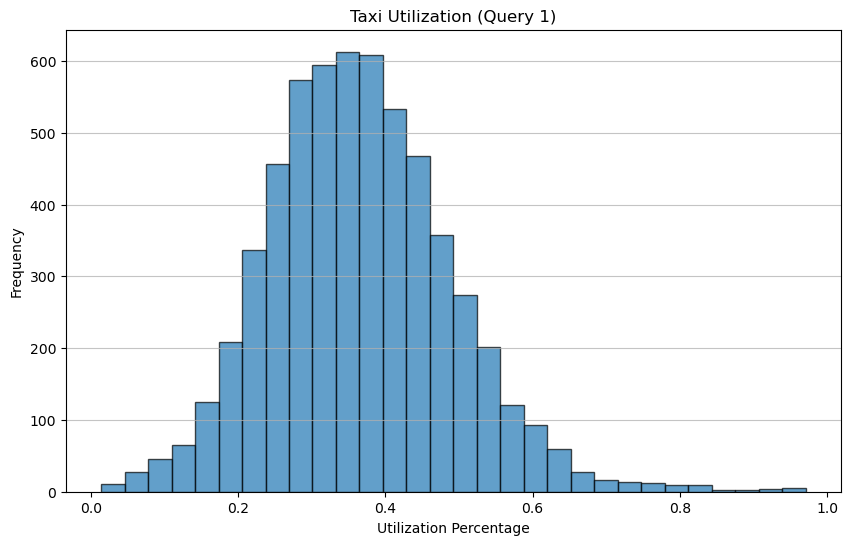

In [146]:
utilization_pd = utilization_df.select("utilization_%").toPandas()

plt.figure(figsize=(10, 6))
plt.hist(utilization_pd["utilization_%"], bins=30, edgecolor='k', alpha=0.7)
plt.title('Taxi Utilization (Query 1)')
plt.xlabel('Utilization Percentage')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

plt.show()


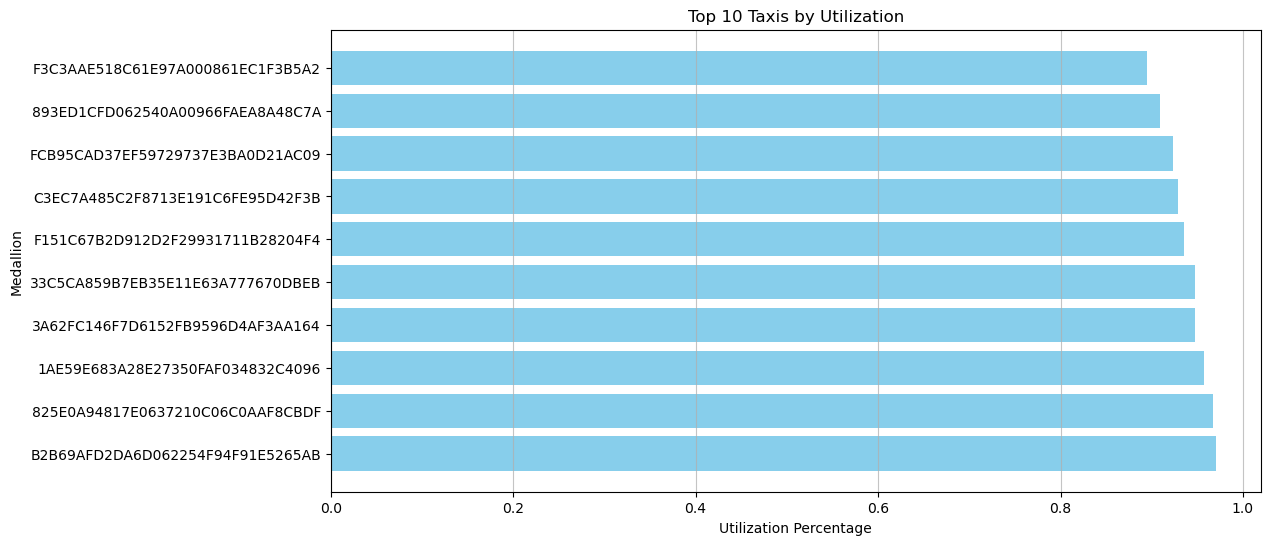

In [147]:
top_10 = utilization_df.orderBy(F.col("utilization_%").desc()).limit(10).toPandas()

plt.figure(figsize=(12, 6))
plt.barh(top_10["medallion"], top_10["utilization_%"], color='skyblue')
plt.title('Top 10 Taxis by Utilization')
plt.xlabel('Utilization Percentage')
plt.ylabel('Medallion')
plt.grid(axis='x', alpha=0.75)

plt.show()

# Query 2

In [148]:
query2_df = (taxi_df
             .withColumn("next_pickup_ts", F.lead("pickup_ts").over(window_taxi))
             .withColumn("time_to_next_fare", F.col("next_pickup_ts") - F.col("dropoff_ts"))
             .filter((F.col("time_to_next_fare") > 0) & (F.col("time_to_next_fare") < 14400))        
             .groupBy("dropoff_borough")
             .agg(F.round(F.avg("time_to_next_fare") / 60, 2).alias("avg_waiting_time_min"))
            )
display(query2_df)

dropoff_borough,avg_waiting_time_min
Queens,50.95
Brooklyn,43.6
Staten Island,45.27
Manhattan,17.58
Bronx,43.52


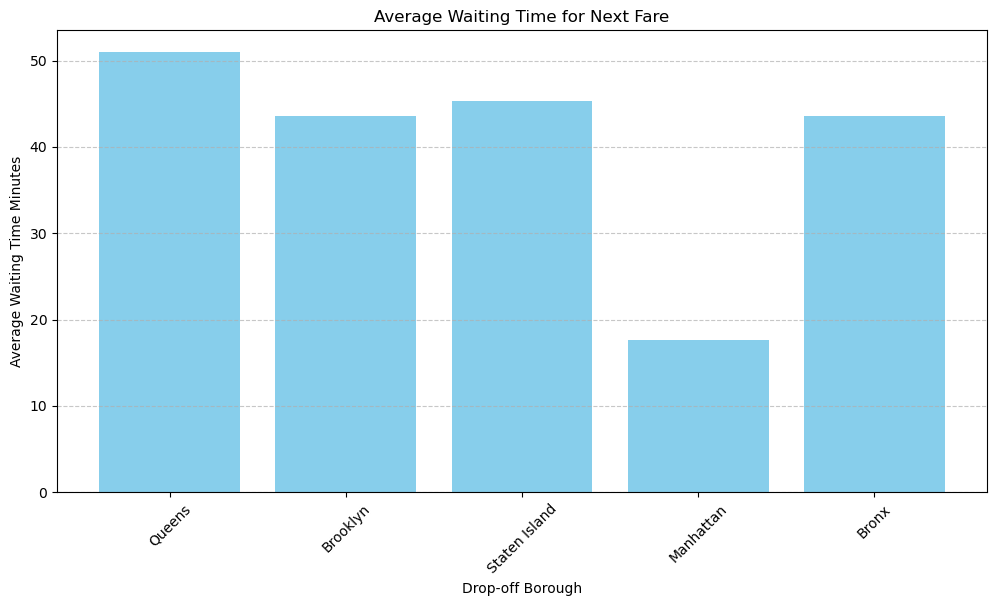

In [149]:
query2_pd = query2_df.toPandas()

plt.figure(figsize=(12, 6))
plt.bar(query2_pd["dropoff_borough"], query2_pd["avg_waiting_time_min"], color='skyblue')
plt.title('Average Waiting Time for Next Fare')
plt.xlabel('Drop-off Borough')
plt.ylabel('Average Waiting Time Minutes')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


# Query 3

In [139]:
# version 1
# start_time = time.time()

# same = taxi_df.filter(F.col("pickup_borough") == F.col("dropoff_borough")).count()

# end_time = time.time()

# print(f"Number of drives started and ended in the same boroughs {same}.")
# total = end_time - start_time
# print(f"Time taken: {round(total, 2)} seconds")

In [140]:
# version 2
start_time = time.time()

same = taxi_df.filter(F.col("pickup_borough") == F.col("dropoff_borough")).count()

end_time = time.time()

print(f"Number of drives started and ended in the same boroughs {same}.")
total = end_time - start_time
print(f"Time taken: {round(total, 2)} seconds")

Number of drives started and ended in the same boroughs 86080.
Time taken: 3.83 seconds


# Query 4

In [141]:
# version 1
# start_time = time.time()

# diff = taxi_df.filter(F.col("pickup_borough") != F.col("dropoff_borough")).count()

# end_time = time.time()

# print(f"Number of drives started and ended in the different boroughs {diff}.")
# total = end_time - start_time
# print(f"Time taken: {round(total)} seconds")

In [142]:
# version 2
start_time = time.time()

diff = taxi_df.filter(F.col("pickup_borough") != F.col("dropoff_borough")).count()

end_time = time.time()

print(f"Number of drives started and ended in the different boroughs {diff}.")
total = end_time - start_time
print(f"Time taken: {round(total, 2)} seconds")

Number of drives started and ended in the different boroughs 11721.
Time taken: 3.88 seconds
